In [2]:
import os
import re
from Bio import SeqIO
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import seaborn as sns
from scipy import stats
from collections import defaultdict
from adjustText import adjust_text

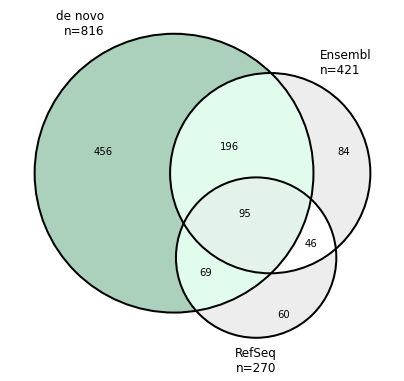

In [3]:
with open('../data/finz_znf_overlap_70.txt') as infile:
    overlap = [int(line.split()[-1]) for line in infile]
ndenovo = overlap[0] + overlap[2] + overlap[4] + overlap[6]
nensembl = overlap[1] + overlap[2] + overlap[5] + overlap[6]
nrefseq = overlap[3] + overlap[4] + overlap[5] + overlap[6]

# (A, B, AB, C, AC, BC, ABC)
fig, ax = plt.subplots(figsize=(7, 7))
venn3(subsets=overlap, 
      set_labels=(f'de novo\nn={ndenovo}', f'Ensembl\nn={nensembl}', f'RefSeq\nn={nrefseq}'), 
      set_colors=('seagreen', 'lightgrey', 'lightgrey'),)
venn3_circles(subsets=overlap)
fig.savefig('../figs/annotation_venn.pdf', bbox_inches='tight', dpi=300)
fig.savefig('../figs/annotation_venn.png', bbox_inches='tight', dpi=300)
plt.show()

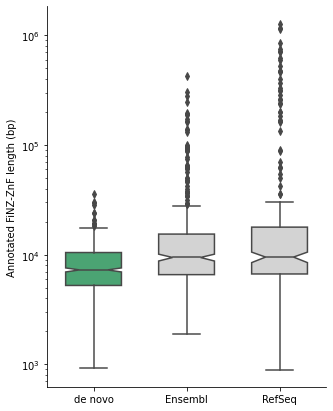

    source  count          mean            std     min     25%     50%  \
0  Ensembl  421.0  20123.560570   39940.273811  1883.0  6583.0  9437.0   
1   RefSeq  281.0  60732.729537  174045.252735   899.0  6676.0  9517.0   
2  de novo  705.0   8157.367376    4058.771471   930.0  5246.0  7270.0   

       75%        max      iqr  
0  15419.0   421032.0   8836.0  
1  17839.0  1278443.0  11163.0  
2  10470.0    35606.0   5224.0  


In [7]:
annotations = {'de novo': '/Users/jonwells/Projects/feschottelab/finz-znf/scripts/gene-annotation/denovo.gff',
               'Ensembl': '../data/gffs/ensembl_finz_znf.gff',
               'RefSeq': '../data/gffs/refseq_finz_znf.gff'}
genelengths = defaultdict(list)
for key, filename in annotations.items():    
    with open(filename) as infile:
        for line in infile:
            if "\tgene\t" in line:
                line = line.split()
                genelengths['length'].append(abs(int(line[4]) - int(line[3])))
                genelengths['source'].append(key)
length_df = pd.DataFrame.from_dict(genelengths)
# length_df['log10_length'] = np.log(length_df['length'])

fig, ax = plt.subplots(figsize=(5,7))
sns.boxplot(data=length_df, y='length', x='source', 
            palette=['mediumseagreen', 'lightgrey', 'lightgrey'],
            notch=True,
            width=0.6,
            ax=ax)
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('Annotated FiNZ-ZnF length (bp)')
sns.despine()
plt.show()
fig.savefig('../figs/annotation_lengths.pdf', bbox_inches='tight')
fig.savefig('../figs/annotation_lengths.png', bbox_inches='tight')

length_summary = length_df.groupby('source')['length'].describe().reset_index()
length_summary['iqr'] = length_summary['75%'] - length_summary['25%']
print(length_summary)

In [3]:
def calc_N50(genomefile):
    contiglens = []
    for record in SeqIO.parse(genomefile, 'fasta'):
        contiglens.append(len(record.seq))
    contiglens = sorted(contiglens, reverse=True)
    gsize = sum(contiglens)
    i, currentsize = 0, 0
    while currentsize <= gsize*0.5:
        currentsize += contiglens[i]
        i += 1
    return contiglens[i]

def calc_busco(buscofile, value):
    buscopat = '\s+C:([\d\.]+)%\[S:([\d\.]+)%,D:([\d\.]+)%\],F:([\d\.]+)%,M:([\d\.]+)%,n:(\d+)'
    with open(buscofile) as infile:
        for line in infile:
            hit = re.search(buscopat, line)
            if hit:
                vals = [float(i) for i in hit.groups()]
                busco = dict(zip(('complete', 
                                  'singleton', 
                                  'duplicate', 
                                  'failed', 
                                  'missing', 
                                  'n'), 
                                 vals))
                break
    return busco[value]


In [4]:
with open('../data/species_genomes.txt') as infile:
    genomes = {line.split()[0]: f'/Users/jonwells/Genomes/Cypriniformes/ncbi-genomes-2020-07-09/{line.split()[1]}' for line in infile}

n50s = []
for species, genomefile in genomes.items():
    print(species)
    n50s.append((species, calc_N50(genomefile)))
n50_df = pd.DataFrame(n50s, columns=['species', 'N50'])

Chanos_chanos
Pimephales_promelas
Cyprinus_carpio
Ctenopharyngodon_idella
Sinocyclocheilus_anshuiensis
Sinocyclocheilus_rhinocerous
Sinocyclocheilus_grahami
Carassius_auratus
Oxygymnocypris_stewartii
Anabarilius_grahami
Cirrhinus_molitorella
Labeo_rohita
Labeo_catla
Labeo_gonius
Poropuntius_huangchuchieni
Hypophthalmichthys_nobilis
Hypophthalmichthys_molitrix
Triplophysa_siluroides
Triplophysa_tibetana
Triplophysa_dalaica
Culter_alburnus
Megalobrama_amblycephala
Onychostoma_macrolepis
Leuciscus_waleckii
Paedocypris_carbunculus
Paedocypris_micromegethes
Danionella_dracula
Danionella_translucida
Danio_albolineatus
Danio_jaintianensis
Danio_choprai
Danio_aesculapii
Danio_kyathit
Danio_tinwini
Danio_rerio


In [179]:
buscos = []
for species in genomes.keys():
    for file in os.listdir(f'../data/busco-out/{species}'):
        buscofile = f'../data/busco-out/{species}/{file}'
        buscos.append((species, 
                       calc_busco(buscofile, 'complete')))
busco_df = pd.DataFrame(buscos, columns=['species', 'busco_complete'])

In [219]:
qc_df = pd.merge(n50_df, busco_df, on='species')
qc_df = pd.merge(pd.read_csv('../data/finz_te_counts.txt', sep='\t')[['species', 'finz_znf', 'finz_exons']], qc_df, on='species')
qc_df = qc_df.sort_values('busco_complete').reset_index().drop('index', 1)
print(qc_df)

                         species  finz_znf  finz_exons       N50  \
0                   Labeo_gonius        28         193      3580   
1          Cirrhinus_molitorella        41         549      4199   
2     Poropuntius_huangchuchieni         8         322      2931   
3            Pimephales_promelas        32         393     60365   
4                  Danio_choprai        70         108   5574156   
5             Leuciscus_waleckii        76         352  21776898   
6        Paedocypris_carbunculus         0           0     59221   
7             Danio_albolineatus       340         598   4543946   
8      Paedocypris_micromegethes         0           0     61829   
9                  Danio_tinwini       118         178  13167244   
10               Cyprinus_carpio       187         664   7653411   
11    Hypophthalmichthys_nobilis        85         343     83001   
12           Danio_jaintianensis        93         132  17381796   
13   Hypophthalmichthys_molitrix        31      

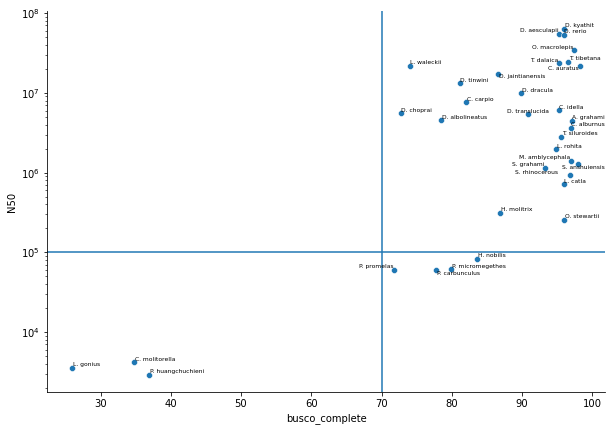

In [251]:
min_n50 = 1e05
min_busco = 70
with open('../data/hiqual_species.txt', 'w') as outfile:
    spec = list(qc_df.loc[(qc_df.N50 > min_n50) & (qc_df.busco_complete > min_busco), 'species'])
    outfile.write('\n'.join(spec))
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=qc_df, x='busco_complete', y='N50')
ax.set_yscale('log')
ax.axvline(x=min_busco)
ax.axhline(y=min_n50)
labels = []
for row in qc_df.iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax.text(row[1]['busco_complete'], row[1]['N50'], label, size=6, va='center', ha='center'))
adjust_text(labels)

sns.despine()
plt.show()
fig.savefig('../figs/n50_vs_busco.pdf', bbox_inches='tight', dpi=300)
fig.savefig('../figs/n50_vs_busco.png', bbox_inches='tight', dpi=300)

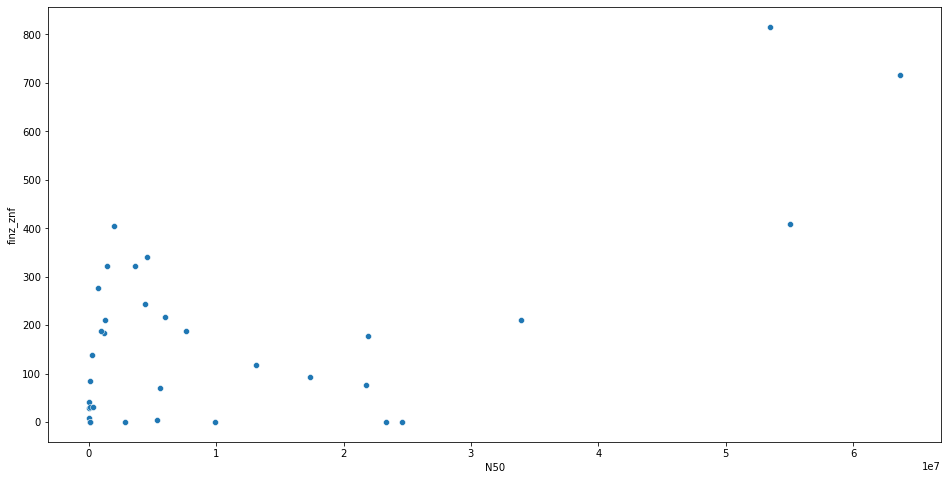

In [234]:
# # Before
# qc_df = qc_df.loc[qc_df.finz+ > 0]
# print(stats.spearmanr(qc_df['nfinz'], qc_df['N50']))
# print(stats.spearmanr(qc_df['nfinz'], qc_df['busco_complete']))

# # After
# print(stats.spearmanr(qc_df.loc[qc_df.species.isin(spec), 'nfinz'],
#                       qc_df.loc[qc_df.species.isin(spec), 'N50']))
# print(stats.spearmanr(qc_df.loc[qc_df.species.isin(spec), 'nfinz'],
#                       qc_df.loc[qc_df.species.isin(spec), 'busco_complete']))
fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(data=qc_df.loc[qc_df.finz_exons >= 0], 
                x='N50',
                y='finz_znf',
                ax=ax)
# sns.scatterplot(data=qc_df.loc[qc_df.finz_exons >= 0], 
#                 x='busco_complete',
#                 y='finz_znf',
#                 ax=ax[0][1])
# sns.scatterplot(data=qc_df.loc[(qc_df.finz_exons >= 0) & (qc_df.species.isin(spec))], 
#                 x='N50',
#                 y='finz_znf',
#                 ax=ax[1][0])
# sns.scatterplot(data=qc_df.loc[(qc_df.finz_exons >= 0) & (qc_df.species.isin(spec))], 
#                 x='busco_complete',
#                 y='finz_znf',
#                 ax=ax[1][1])

# ax[0][0].set_xscale('log')
# ax[1][0].set_xscale('log')

plt.show()

In [8]:
coverage_df = pd.DataFrame(columns=['gene', 'position', 'depth', 'busco', 'species'])
for species in ['Danio_choprai', 'Danio_jaintianensis', 'Danio_albolineatus', 'Danio_tinwini']:
    df = pd.read_csv(f'../data/danio-reads/{species}_depth75.out', 
                     sep='\t', 
                     header=None, 
                     names=['gene', 'position', 'depth'])
    df['busco'] = False
    df.loc[df.gene.str.contains('\d+at\d+'), 'busco'] = True
    df['species'] = species
    coverage_df = pd.concat([coverage_df, df])
coverage_df['depth'] = coverage_df.depth.apply(pd.to_numeric)
genecov_df = coverage_df.groupby(['species', 'gene', 'busco']).median().reset_index()
print(genecov_df.head())

              species                             gene  busco  depth
0  Danio_albolineatus  Danio_albolineatus_100028at7898   True   16.0
1  Danio_albolineatus  Danio_albolineatus_100034at7898   True   14.0
2  Danio_albolineatus  Danio_albolineatus_100316at7898   True   16.0
3  Danio_albolineatus  Danio_albolineatus_100418at7898   True   13.0
4  Danio_albolineatus  Danio_albolineatus_100571at7898   True   15.0


In [9]:
genecov_df['norm'] = 0
for species in ['Danio_choprai', 'Danio_jaintianensis', 'Danio_albolineatus', 'Danio_tinwini']:
    genecov_df.loc[genecov_df.species == species, 'norm'] = genecov_df.loc[genecov_df.species == species, 'depth'] - genecov_df.loc[genecov_df.species == species, 'depth'].mean()
 


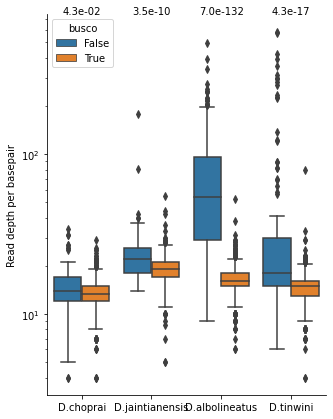

In [245]:
fig, ax = plt.subplots(figsize=(5, 7))
sns.boxplot(data=genecov_df, 
            x='species', 
            y='depth', 
            hue='busco', 
            order=['Danio_choprai', 'Danio_jaintianensis', 'Danio_albolineatus', 'Danio_tinwini'],
            ax=ax)
ax.set_yscale('log')
ax.set_ylabel('Read depth per basepair')
ax.set_xlabel('')
ax.set_xticklabels(['D.choprai', 'D.jaintianensis', 'D.albolineatus', 'D.tinwini'])

i = 0
for species in ['Danio_choprai', 'Danio_jaintianensis', 'Danio_albolineatus', 'Danio_tinwini']:
    pval = stats.ranksums(genecov_df.loc[(genecov_df.species == species) & (genecov_df.busco == True), 'depth'],
                          genecov_df.loc[(genecov_df.species == species) & (genecov_df.busco == False), 'depth'])[1]
    ax.text(x=i, y=750, s=f'{pval:.1e}', horizontalalignment='center')
#     ax.axline((i-0.1, 750), (i+0.1, 750))
    i += 1

sns.despine()
plt.show()
fig.savefig('../figs/busco_fznf_read_coverage.pdf', bbox_inches='tight', dpi=300)
fig.savefig('../figs/busco_fznf_read_coverage.png', bbox_inches='tight', dpi=300)

In [11]:
gff_files = {'newannot': '../data/gffs/Danio_rerio_augustus_finz_only.gff',
             'ensembl': '../data/gffs/ensembl_finz_znf.gff',
             'refseq': '../data/gffs/refseq_finz_znf.gff'}

gffs = {}

for source, filename in gff_files.items():
    gffs[source] = defaultdict(int)
    if source == 'newannot':
        id_pattern = re.compile('ID=(\w+)')
    elif source == 'ensembl':
        id_pattern = re.compile('gene_id=(.+)?;')
    elif source == 'refseq':
        id_pattern = re.compile('gene=(.+)?;')
    
    with open(filename) as infile:
        for line in infile:
            if line.startswith('#'):
                continue
            line = line.split()
            if line[2] == 'gene':
                gid = re.search(id_pattern, line[-1]).group(1)
            elif line[2] == 'CDS':
                gffs[source][gid] += 1


exon_df = pd.DataFrame(columns=['gene', 'exons', 'source'], dtype=int)
for source, exons in gffs.items():
    exon_df = pd.concat([exon_df, pd.DataFrame([(key, val, source) for key, val in exons.items()], columns=['gene', 'exons', 'source'])])
print(exon_df.head())

  gene  exons    source
0   g9      2  newannot
1  g10      2  newannot
2  g12      3  newannot
3  g13      4  newannot
4  g19      2  newannot


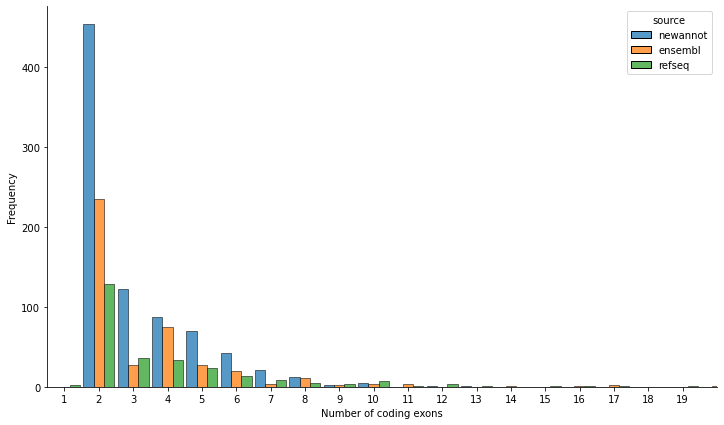

In [106]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.histplot(data=exon_df, x='exons', hue='source', multiple='dodge', discrete=True, shrink=0.9, stat='count')
# sns.kdeplot(data=exon_df, x='exons', hue='source', bw=0.1)
ax.set_xticks([i for i in range(1, 20)])
ax.set_xlim(0.5, 20)
ax.set_xlabel('Number of coding exons')
ax.set_ylabel('Frequency')
sns.despine()
plt.show()